In [4]:

!pip install sparqlwrapper


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 500 kB 11.2 MB/s 
     |████████████████████████████████| 41 kB 687 kB/s 


## INTER DESC-EN SPECIFICITY INDEX

BASED ON THE LAFON INDEX : https://www.persee.fr/doc/mots_0243-6450_1980_num_1_1_1008
 WE try to find here the most specifics named entited regarding to the descriptors
 with sparql we compute : 
 * t : the total number of named entity tags used in combination to the chosen descriptor
 * T : the total number of named entity tags used in the corpus
 * f : the frequencies of the 150th most used entity named related to a descriptor
 * F : the frequencies of the last 150th entity the corpus

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 28 23:06:56 2022

@author: cringwal
"""

from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
from scipy.stats import hypergeom
import matplotlib.pyplot as plt


descriptor="<http://aims.fao.org/aos/agrovoc/c_7713>"


In [68]:

tent_dict= {'wikidata': 'issa:EntityFishing',
              'geonames': 'issa:GeographicEntityExtractor',
              'dbpedia' : 'issa:DBPediaSpotlight',
              'agrovoc' : 'issa:Pyclinrec'}
tdesc_dict = {'manuel': 'issa:AgritropDocumentalist',
              'auto': 'issa:AnnifSubjectIndexer'}

def getSpecificityData(descriptor,type_desc="manuel",type_ent="agrovoc"):
  endpoint_url="http://erebe-vm20.i3s.unice.fr:8890/sparql"
  
  type_d=tdesc_dict[type_desc]
  type_e=tent_dict[type_ent]

  print("- CHOSEN ENDPOINT > ",endpoint_url)
  print("- descriptor : ",descriptor)
  print("- type_desc : ",type_desc)
  print("- CHOSEN type_ent : ",type_ent)
  
  print("---- compute t & T")
  sparql_t = SPARQLWrapper(endpoint_url)

  sparql_t.setQuery("""
  prefix dct:	<http://purl.org/dc/terms/>
  prefix fabio:     <http://purl.org/spar/fabio/>
  prefix frbr: <http://purl.org/vocab/frbr/core#>
  prefix issa: <http://data-issa.cirad.fr/>
  prefix oa:     <http://www.w3.org/ns/oa#>
  prefix prov:   <http://www.w3.org/ns/prov#>
  prefix skosxl: <http://www.w3.org/2008/05/skos-xl#>


  SELECT COUNT(DISTINCT ?cat) as ?nb
  WHERE { 
  ?desc a issa:ThematicDescriptorAnnotation;
  prov:wasAttributedTo """+type_d+""";
  oa:hasTarget ?paper;
  oa:hasBody """+descriptor+""".
  ?entity a prov:Entity; schema:about ?paper;
  oa:hasBody ?cat;
  prov:wasAttributedTo """+type_e+""".
  } 
  """)

  sparql_t.setReturnFormat(JSON)
  results_t = sparql_t.query().convert()

  sparql_T = SPARQLWrapper(endpoint_url)

  sparql_T.setQuery("""
  prefix dct:	<http://purl.org/dc/terms/>
  prefix fabio:     <http://purl.org/spar/fabio/>
  prefix frbr: <http://purl.org/vocab/frbr/core#>
  prefix issa: <http://data-issa.cirad.fr/>
  prefix oa:     <http://www.w3.org/ns/oa#>
  prefix prov:   <http://www.w3.org/ns/prov#>
  prefix skosxl: <http://www.w3.org/2008/05/skos-xl#>


  SELECT COUNT(DISTINCT ?cat) as ?nb
  WHERE { 
    ?desc a issa:ThematicDescriptorAnnotation;
    prov:wasAttributedTo """+type_d+""";
    oa:hasTarget ?paper.
    ?entity a prov:Entity; schema:about ?paper;
    oa:hasBody ?cat;
    prov:wasAttributedTo """+type_e+""".
  } 
  """)

  sparql_T.setReturnFormat(JSON)
  results_T = sparql_T.query().convert()
  T=int(results_T['results']['bindings'][0]['nb']['value'])
  t=int(results_t['results']['bindings'][0]['nb']['value'])
  print("==> t=",t," / T=",T)

  print("---- compute f & F")
  sparql_f = SPARQLWrapper(endpoint_url)

  sparql_f.setQuery("""
  prefix issapr: <http://data-issa.cirad.fr/property/>
  prefix dct:	<http://purl.org/dc/terms/>
  prefix fabio:     <http://purl.org/spar/fabio/>
  prefix frbr: <http://purl.org/vocab/frbr/core#>
  prefix issa: <http://data-issa.cirad.fr/>
  prefix oa:     <http://www.w3.org/ns/oa#>
  prefix prov:   <http://www.w3.org/ns/prov#>
  prefix skosxl: <http://www.w3.org/2008/05/skos-xl#>


  SELECT ?cat COUNT(DISTINCT ?paper) as ?nb_desc
  WHERE { 
    ?desc a issa:ThematicDescriptorAnnotation;
    prov:wasAttributedTo """+type_d+""";
    oa:hasTarget ?paper;
    oa:hasBody """+descriptor+""".
    ?entity a prov:Entity; schema:about ?paper;
    oa:hasBody ?cat;
    prov:wasAttributedTo """+type_e+""".

  } GROUP BY ?cat 
  ORDER BY DESC( ?nb_desc) LIMIT 100
  """)
  sparql_f.setReturnFormat(JSON)
  results_f = sparql_f.query().convert()


  df_f = pd.io.json.json_normalize(results_f['results']['bindings'])


  sparql_F = SPARQLWrapper(endpoint_url)

  sparql_F.setQuery("""
  prefix issapr: <http://data-issa.cirad.fr/property/>
  prefix dct:	<http://purl.org/dc/terms/>
  prefix fabio:     <http://purl.org/spar/fabio/>
  prefix frbr: <http://purl.org/vocab/frbr/core#>
  prefix issa: <http://data-issa.cirad.fr/>
  prefix oa:     <http://www.w3.org/ns/oa#>
  prefix prov:   <http://www.w3.org/ns/prov#>
  prefix skosxl: <http://www.w3.org/2008/05/skos-xl#>


  SELECT ?cat COUNT(DISTINCT ?paper) as ?nb_all
  WHERE { 
  ?desc a issa:ThematicDescriptorAnnotation;
  prov:wasAttributedTo """+type_d+""";
  oa:hasTarget ?paper;
  oa:hasBody ?p.
  ?entity a prov:Entity; schema:about ?paper;
  oa:hasBody ?cat;
  prov:wasAttributedTo """+type_e+""".
  FILTER( ?cat IN ( <"""
  +">, <".join(list(df_f["cat.value"]))+
  """> ) ).

  } GROUP BY ?cat 
  ORDER BY DESC(?nb_all)
  """)
  sparql_F.setReturnFormat(JSON)
  results_F = sparql_F.query().convert()
  df_F = pd.io.json.json_normalize(results_F['results']['bindings'])

  print("==> F:")
  print(df_F)

  results_frequences = pd.merge(df_f, df_F, how="right", on=["cat.value", "cat.value"])
  results_frequences

  if(type_ent=="agrovoc"):
    print("---- get labels")
    sparql_labels = SPARQLWrapper(endpoint_url)

    sparql_labels.setQuery("""
    prefix issapr: <http://data-issa.cirad.fr/property/>
    prefix dct:	<http://purl.org/dc/terms/>
    prefix fabio:     <http://purl.org/spar/fabio/>
    prefix frbr: <http://purl.org/vocab/frbr/core#>
    prefix issa: <http://data-issa.cirad.fr/>
    prefix oa:     <http://www.w3.org/ns/oa#>
    prefix prov:   <http://www.w3.org/ns/prov#>
    prefix skosxl: <http://www.w3.org/2008/05/skos-xl#>


    SELECT ?cat ?altLabel
    WHERE { 
    ?entity oa:hasBody ?cat;
    prov:wasAttributedTo issa:Pyclinrec.
    FILTER( ?cat IN ( <"""
    +">, <".join(list(df_f["cat.value"]))+
    """> ) ).
    ?cat skosxl:altLabel/skosxl:literalForm ?altLabel . 
    FILTER(lang(?altLabel) = "en") 
    } 
    ORDER BY DESC(COUNT(DISTINCT ?paper))
    """)
    sparql_labels.setReturnFormat(JSON)
    results_labels = sparql_labels.query().convert()
    df_labels = pd.io.json.json_normalize(results_labels['results']['bindings'])
    results_withlabels = pd.merge(results_frequences, df_labels, how="right", on=["cat.value", "cat.value"])
  else:
    results_withlabels=results_frequences

  print("---- do stat tests")
  dict_result=[]
  for index, row in results_withlabels.iterrows():
      f=int(row["nb_desc.value"])
      F=int(row["nb_all.value"])

      k=(F*t)/T # CALCUL DE K
      prb_f_est1 = hypergeom.cdf(f, T, F, t)
      
      
      # CAS SIGNIFICATIVITE POSITIVE
      if(f>k):
          # DONNE PROBAS DE k à F-1
          
          sign=1
          # INVERSE POUR AVOIR P(X>f)
          S_est1=1-prb_f_est1
      # CAS SIGNIFICATIVITE NEGATIVE
      else:
          sign=-1
          # 
          S_est1=prb_f_est1
      
      k=round(k)
      
      ###### CALCUL DE l'INDICE DE SPECIFICITE
      idx_est1=(0.5-S_est1)/0.5
      idx_final_est1=idx_est1*10*sign
      #ENRIGISTREMENT DANS LE DICO
      
      if(type_ent=="agrovoc"):
        label=row["altLabel.value"]
      else:
        label=row["cat.value"]
      dict_result.append({"label":label,"F":F,"f":f,"k":k,"sign":sign,"Prob_est1":prb_f_est1,"S_est1":S_est1,"indice_final_est1":idx_final_est1})
     
  return dict_result

In [73]:
res=getSpecificityData("<http://aims.fao.org/aos/agrovoc/c_7713>","manuel")

- CHOSEN ENDPOINT >  http://erebe-vm20.i3s.unice.fr:8890/sparql
- descriptor :  <http://aims.fao.org/aos/agrovoc/c_7713>
- type_desc :  manuel
- CHOSEN type_ent :  agrovoc
---- compute t & T
==> t= 3985  / T= 17746
---- compute f & F


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


==> F:
   cat.type                                   cat.value    nb_all.type  \
0       uri  http://aims.fao.org/aos/agrovoc/c_8c3ecd25  typed-literal   
1       uri      http://aims.fao.org/aos/agrovoc/c_3815  typed-literal   
2       uri      http://aims.fao.org/aos/agrovoc/c_6200  typed-literal   
3       uri      http://aims.fao.org/aos/agrovoc/c_8117  typed-literal   
4       uri      http://aims.fao.org/aos/agrovoc/c_6211  typed-literal   
..      ...                                         ...            ...   
95      uri      http://aims.fao.org/aos/agrovoc/c_3707  typed-literal   
96      uri      http://aims.fao.org/aos/agrovoc/c_3706  typed-literal   
97      uri      http://aims.fao.org/aos/agrovoc/c_1229  typed-literal   
98      uri      http://aims.fao.org/aos/agrovoc/c_7713  typed-literal   
99      uri     http://aims.fao.org/aos/agrovoc/c_13475  typed-literal   

                             nb_all.datatype nb_all.value  
0   http://www.w3.org/2001/XMLSchema#integer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [70]:
res

[{'label': 'http://www.wikidata.org/entity/Q142',
  'F': 2613,
  'f': 31,
  'k': 180,
  'sign': -1,
  'Prob_est1': 3.0788806058145325e-46,
  'S_est1': 3.0788806058145325e-46,
  'indice_final_est1': -10.0},
 {'label': 'http://www.wikidata.org/entity/Q15',
  'F': 2187,
  'f': 34,
  'k': 151,
  'sign': -1,
  'Prob_est1': 8.288906422118704e-33,
  'S_est1': 8.288906422118704e-33,
  'indice_final_est1': -10.0},
 {'label': 'http://www.wikidata.org/entity/Q36784',
  'F': 1762,
  'f': 30,
  'k': 122,
  'sign': -1,
  'Prob_est1': 7.021609352461321e-25,
  'S_est1': 7.021609352461321e-25,
  'indice_final_est1': -10.0},
 {'label': 'http://www.wikidata.org/entity/Q11451',
  'F': 1689,
  'f': 26,
  'k': 117,
  'sign': -1,
  'Prob_est1': 1.0309659712537458e-25,
  'S_est1': 1.0309659712537458e-25,
  'indice_final_est1': -10.0},
 {'label': 'http://www.wikidata.org/entity/Q2945274',
  'F': 1578,
  'f': 42,
  'k': 109,
  'sign': -1,
  'Prob_est1': 2.5195120313518142e-14,
  'S_est1': 2.5195120313518142e-14

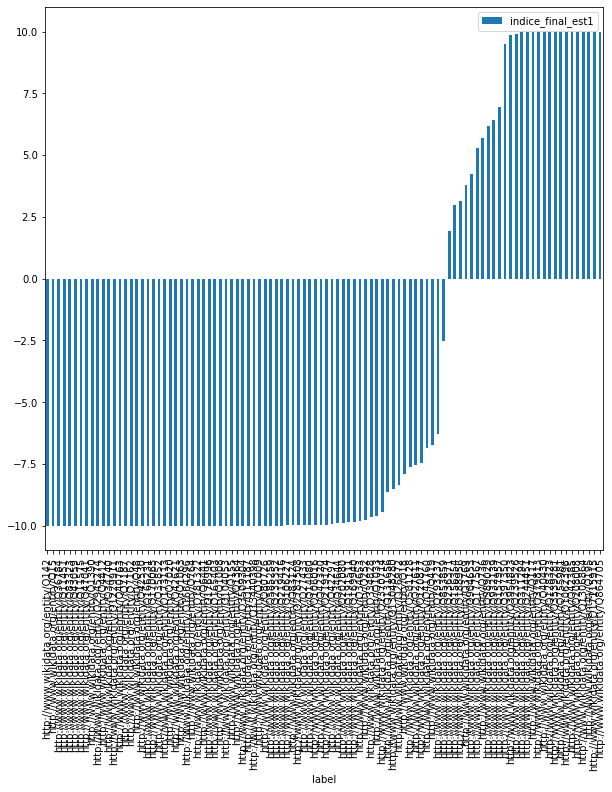

In [71]:
df = pd.DataFrame(res)
df.sort_values(by=['indice_final_est1']).plot(kind='bar',x='label',y='indice_final_est1',figsize=(10, 10))

,label,F,f,k,sign,Prob_est1,S_est1,indice_final_est1
0,cacao (plant),191,179,42,1,1.000000e+00,1.298983e-11,10.0
1,overhead costs,1614,81,356,-1,1.870159e-87,1.870159e-87,-10.0
2,sausage casings,1666,86,368,-1,1.355313e-88,1.355313e-88,-10.0
3,organisations,1832,90,405,-1,1.684834e-101,1.684834e-101,-10.0
4,machinery,3729,116,824,-1,2.144383e-287,2.144383e-287,-10.0
...,...,...,...,...,...,...,...,...
64,ecological zonation,2158,95,477,-1,4.947589e-130,4.947589e-130,-10.0
65,ecological zones,2158,95,477,-1,4.947589e-130,4.947589e-130,-10.0
66,peasants,1125,82,248,-1,2.939163e-43,2.939163e-43,-10.0
67,globalisation,1777,90,392,-1,3.618894e-96,3.618894e-96,-10.0


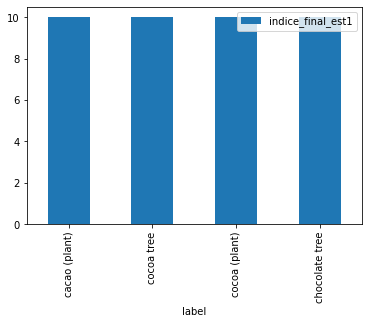

In [44]:

df[df.sign == 1].sort_values(by=['indice_final_est1']).plot(kind='bar',x='label',y='indice_final_est1')